In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcess
from __future__ import print_function
data = np.loadtxt('../Data/models.dat')
import mpld3
import matplotlib.pyplot as pl
import corner
import copy
mpld3.enable_notebook()
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session
pylab.rcParams['font.size'] = 16

In [2]:
print(np.shape(data))

#There are 270 tracks, each of which is 400 steps long. These have all been loaded in
tracks = dict()
for i in range(270):
    tracks[i] = data[0+i*400:400+i*400,0:46]

#Now we just pick out the tracks that have initial mass of 1.7 Msun, and initial metalicity 0.014.
#There are nine of these.
m11p7 = dict()
for i in range(9):
    m11p7[i] = tracks[i]

(108000, 46)


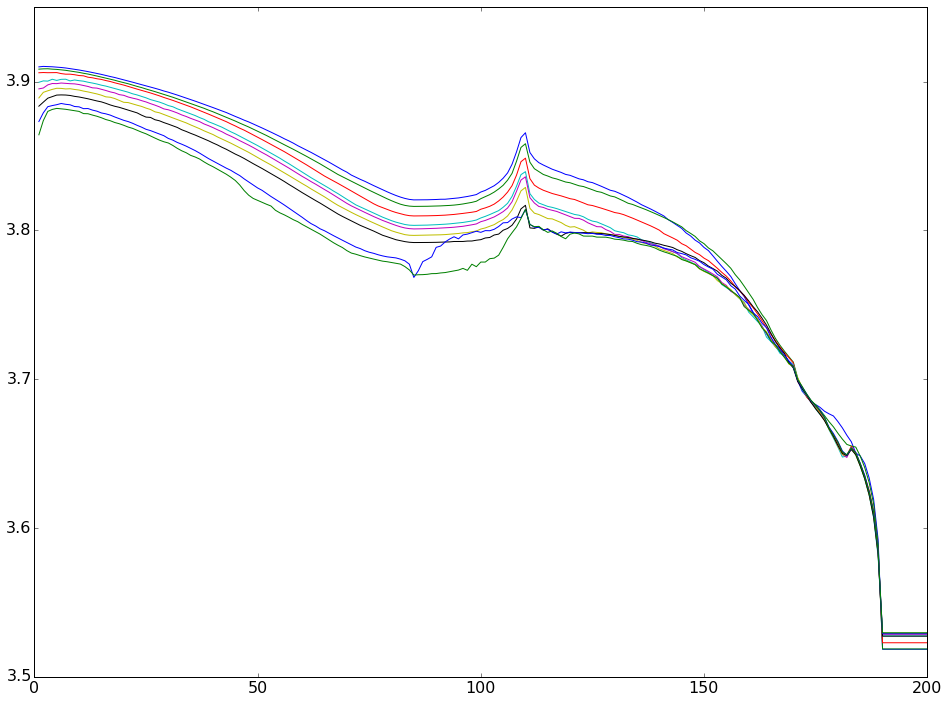

In [3]:
#Now we select just the first 200 time steps to interpolate over.
playdata = dict()
for i in range(9):
    playdata[i] = m11p7[i][0:200]
x = np.linspace(1,200,200)

#and plot the effective temperature as a function of time for the selected simulations
for i in range(9):
    pl.plot(playdata[i][:,3],playdata[i][:,7])
pl.show()

In [4]:
#Ok, so that has picked out nine tracks each with the same mass and metalicity, but varying
#the spin. Now use the predicted log(Teff) to interpolate log(Teff) over all possible values of spin.


dataobs = dict()
omegaobs = dict()
datatest = dict()
omegatest = dict()


for i in range(200):
    dataobs[i] = [playdata[0][i,7],playdata[1][i,7],playdata[4][i,7],playdata[7][i,7],playdata[8][i,7],playdata[2][i,7],playdata[3][i,7],playdata[5][i,7],playdata[6][i,7]]
    omegaobs[i] = [playdata[0][i,2],playdata[1][i,2],playdata[4][i,2],playdata[7][i,2],playdata[8][i,2],playdata[2][i,2],playdata[3][i,2],playdata[5][i,2],playdata[6][i,2]]
    
#What's in these lists? The first number gives the track number - there are 9 of those in playdata. The second
#'number,' which is i, gives the time stamp. 
#The third number gives the omega parameter, for omegaobs, or
# the observable we're interpolating over, for dataobs. In this case, the observable is the log of the effective temp.

XT = dict()
Teff = dict()

#Now we're just setting things up to feed into the GP interpolator. The values to be interpolated are the observed
#value, across the range of omegas. There are 200 time steps. These are delineated by [i]. But *at each i* there is 
#a vector, for omega this contains the points of omega that are observed. For data this contains
#the values at each of those. So y[100] is the 9-d vector containing the observed values at the 9-d vector in X. This 
#all pertains to the time step 100.
for i in range(200):
    XT[i] = np.atleast_2d(np.asarray(omegaobs[i])).T
    Teff[i] = np.asarray(dataobs[i])

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
# So y[0] is at omega = 0, y[1] is at omega = 1/100, etc.
x = np.atleast_2d(np.linspace(0, 1, 100)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)
Teff_pred = dict()
sigmaT = dict()


for i in range(200):
# Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(XT[i],Teff[i])

# Make the prediction on the meshed x-axis (ask for MSE as well)
    Teff_pred[i], MSE = gp.predict(x, eval_MSE=True)
    sigmaT[i] = np.sqrt(MSE)

In [9]:
#Now do the exact same thing, but for the luminosity

dataobsL = dict()
omegaobsL = dict()


for i in range(200):
    dataobsL[i] = [playdata[0][i,6],playdata[1][i,6],playdata[4][i,6],playdata[7][i,6],playdata[8][i,6],playdata[2][i,6],playdata[3][i,6],playdata[5][i,6],playdata[6][i,6]]
    omegaobsL[i] = [playdata[0][i,2],playdata[1][i,2],playdata[4][i,2],playdata[7][i,2],playdata[8][i,2],playdata[2][i,2],playdata[3][i,2],playdata[5][i,2],playdata[6][i,2]]


X = dict()
Lum = dict()

for i in range(200):
    X[i] = np.atleast_2d(np.asarray(omegaobsL[i])).T
    Lum[i] = np.asarray(dataobsL[i])

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
# So y[0] is at omega = 0, y[1] is at omega = 1/50, etc.
x = np.atleast_2d(np.linspace(0, 1, 100)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)
Lum_pred = dict()
sigmaL = dict()


for i in range(200):
# Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X[i],Lum[i])

# Make the prediction on the meshed x-axis (ask for MSE as well)
    Lum_pred[i], MSE = gp.predict(x, eval_MSE=True)
   # sigmaL[i] = np.sqrt(MSE)

[ 0.]


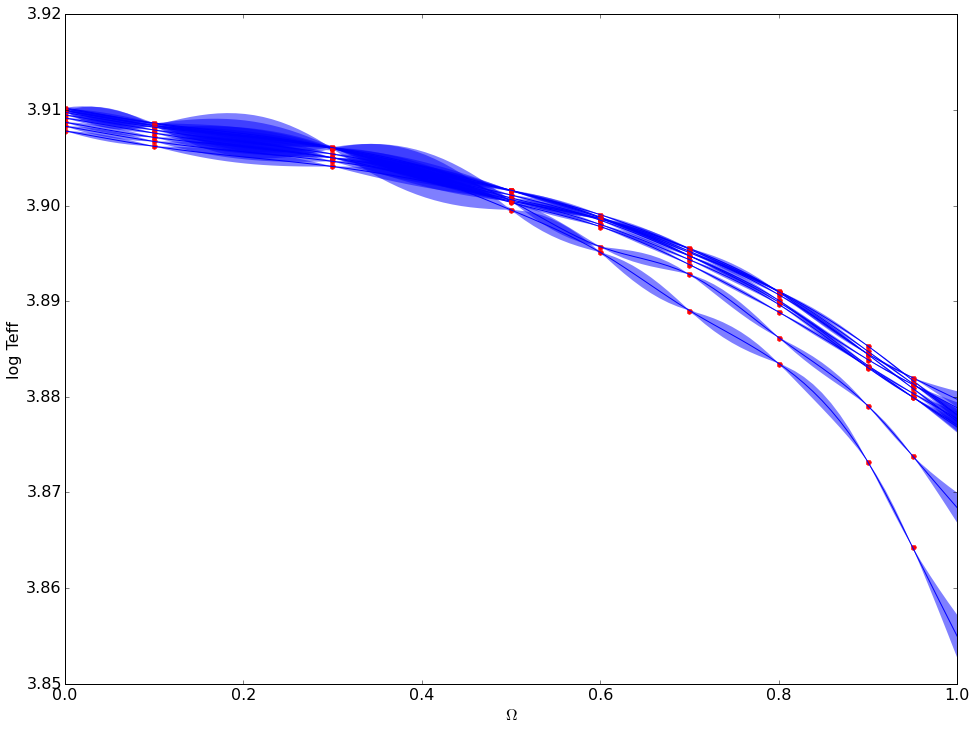

In [7]:
#Plot the interpolated and observed effective temperatures.

print(x[0])
for i in range(10):
    pl.plot(XT[i], Teff[i], 'r.', markersize=10, label=u'Observations')
    pl.plot(x, Teff_pred[i], 'b-', label=u'Prediction')
 #   pl.plot(X[i], Lum[i], 'r.', markersize=10, label=u'Observations')
  #  pl.plot(x, Lum_pred[i], 'g-', label=u'Prediction')
  #  pl.plot(omegatest[i],datatest[i],'xr')
    pl.fill(np.concatenate([x, x[::-1]]),
            np.concatenate([Teff_pred[i] - 1.9600 * sigmaT[i],
                       (Teff_pred[i] + 1.9600 * sigmaT[i])[::-1]]),
            alpha=.5, fc='b',ec='None', label='95% confidence interval')
#pl.legend(loc='lower left')
pl.xlim(0,1)
pl.xlabel(r'$\Omega$')
pl.ylabel('log Teff')


[ 0.]


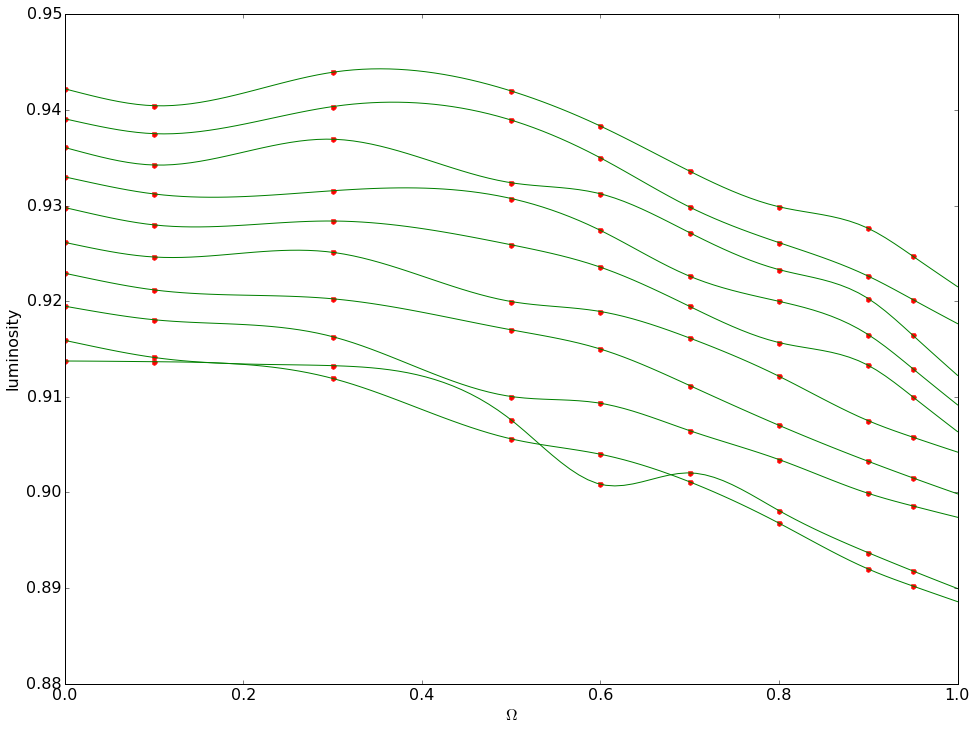

In [11]:
#Plot the observed and interpolated luminosities
print(x[0])
x = np.atleast_2d(np.linspace(0, 1, 100)).T
for i in range(10):
    pl.plot(X[i], Lum[i], 'r.', markersize=10, label=u'Observations')
    pl.plot(x, Lum_pred[i], 'g-', label=u'Prediction')
  #  pl.fill(np.concatenate([x, x[::-1]]),
   #         np.concatenate([Lum_pred[i] - 1.9600 * sigmaL[i],
    #                   (Lum_pred[i] + 1.9600 * sigmaL[i])[::-1]]),
     #       alpha=.5, fc='b',ec='None', label='95% confidence interval')
#pl.legend(loc='lower left')
pl.xlim(0,1)
pl.xlabel(r'$\Omega$')
pl.ylabel('luminosity')


(100,) (100,)
0.915902


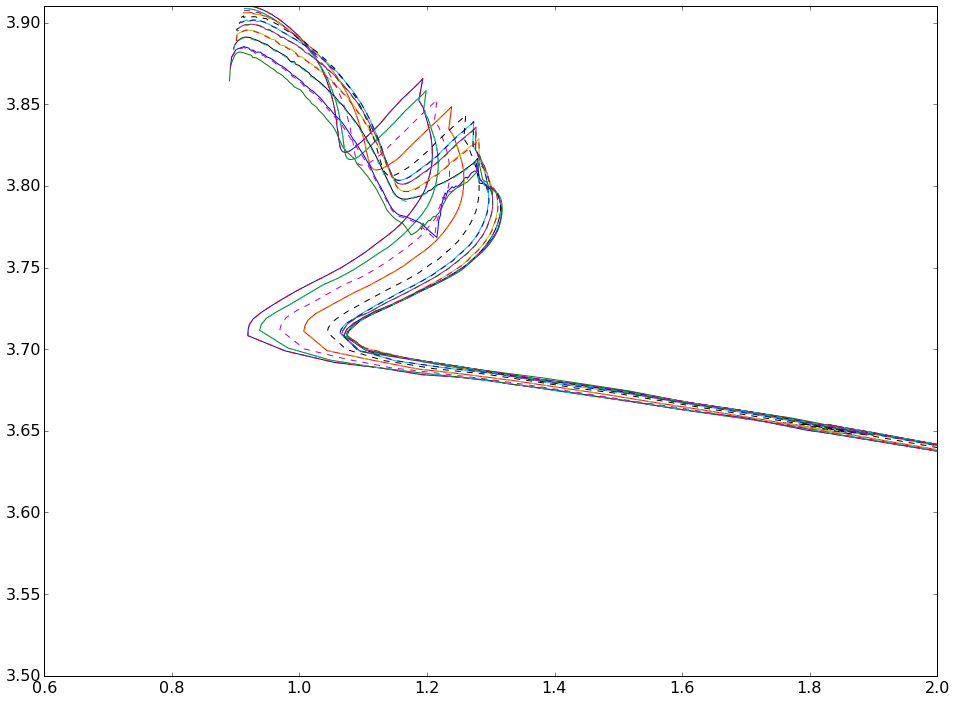

In [13]:
#Finally, plot the interpolated and observed log(Teff) vs. luminosity. The dashed lines are interpolations,
#the solid lines are actual simulations.


Tplot = np.zeros(200)
Tplot2 =np.zeros(200)
Tplot3 =np.zeros(200)
Tplot4 =np.zeros(200)
Tplot5 =np.zeros(200)
Tplot6 =np.zeros(200)
Tplot7 =np.zeros(200)
Tplot8 =np.zeros(200)
Tplot9 =np.zeros(200)
Tplot10 =np.zeros(200)
for i in  range(200):
    Tplot[i] = Teff_pred[i][0]
    Tplot2[i] = Teff_pred[i][10]
    Tplot3[i] = Teff_pred[i][20]
    Tplot4[i] = Teff_pred[i][30]
    Tplot5[i] = Teff_pred[i][40]
    Tplot6[i] = Teff_pred[i][50]
    Tplot7[i] = Teff_pred[i][60]
    Tplot8[i] = Teff_pred[i][70]
    Tplot9[i] = Teff_pred[i][80]
    Tplot10[i] = Teff_pred[i][90]

print(np.shape(Lum_pred[0]), np.shape(Teff_pred[0]))
print(Lum_pred[1][0])

Lplot = np.zeros(200)
Lplot2 =np.zeros(200)
Lplot3 =np.zeros(200)
Lplot4 =np.zeros(200)
Lplot5 =np.zeros(200)
Lplot6 =np.zeros(200)
Lplot7 =np.zeros(200)
Lplot8 =np.zeros(200)
Lplot9 =np.zeros(200)
Lplot10 =np.zeros(200)
for j in  range(200):
    Lplot[j] = Lum_pred[j][0]
    Lplot2[j] = Lum_pred[j][10]
    Lplot3[j] = Lum_pred[j][20]
    Lplot4[j] = Lum_pred[j][30]
    Lplot5[j] = Lum_pred[j][40]
    Lplot6[j] = Lum_pred[j][50]
    Lplot7[j] = Lum_pred[j][60]
    Lplot8[j] = Lum_pred[j][70]
    Lplot9[j] = Lum_pred[j][80]
    Lplot10[j] = Lum_pred[j][90]
    
    

x = np.linspace(0,200,200)

for i in range(9):
    pl.plot(playdata[i][:,6],playdata[i][:,7], label =r'$\Omega=$%s' % playdata[i][0,2])

pl.plot(Lplot,Tplot,'--', label=r'$\Omega=0.84$')
pl.plot(Lplot2,Tplot2,'--')
pl.plot(Lplot3,Tplot3, '--')
pl.plot(Lplot4,Tplot4,'--', label=r'$\Omega=0.92$')
pl.plot(Lplot5,Tplot5, '--')
pl.plot(Lplot6,Tplot6, '--')
pl.plot(Lplot7,Tplot7, '--')
pl.plot(Lplot8,Tplot8, '--')
pl.plot(Lplot9,Tplot9, '--')
pl.plot(Lplot10,Tplot10, '--')
#pl.legend(loc='lower left')
pl.ylim((3.5,3.91))
pl.xlim((0.6,2.0))
#pl.ylabel('log Teff')
#pl.xlabel('time step')
pl.show()

